In [1]:
import matplotlib.pyplot as plt
import numpy as np
import hankel

# We need the spline interpolation to obtain a smooth function that can be transformed back to the original function
from scipy.interpolate import InterpolatedUnivariateSpline as spline

Let's define some functions of r

$$a = \frac{1}{r^2 + 1}$$

$$b = r^2$$

$$c = sin(r) cos(r)$$


In [2]:
a = lambda r: 1 / (np.power(r,2) + 1)
b = lambda r: np.power(r, 2)
c = lambda r: np.sin(r) * np.cos(r)

Define a "analytical" non-filtered approach hankel transform from <i>hankel</i>

In [3]:
ht = hankel.HankelTransform(nu=1, N=500, h=0.0005)

In [4]:
realspace = np.linspace(-10, 10, 150)  #  Realspace domain
hankelspace = np.logspace(-4, 4, 300) #  Hankel space domain

In [5]:
h_a = ht.transform(a, hankelspace, ret_err=False)
h_b = ht.transform(b, hankelspace, ret_err=False)
h_c = ht.transform(c, hankelspace, ret_err=False)

(-1.0, 1.0)

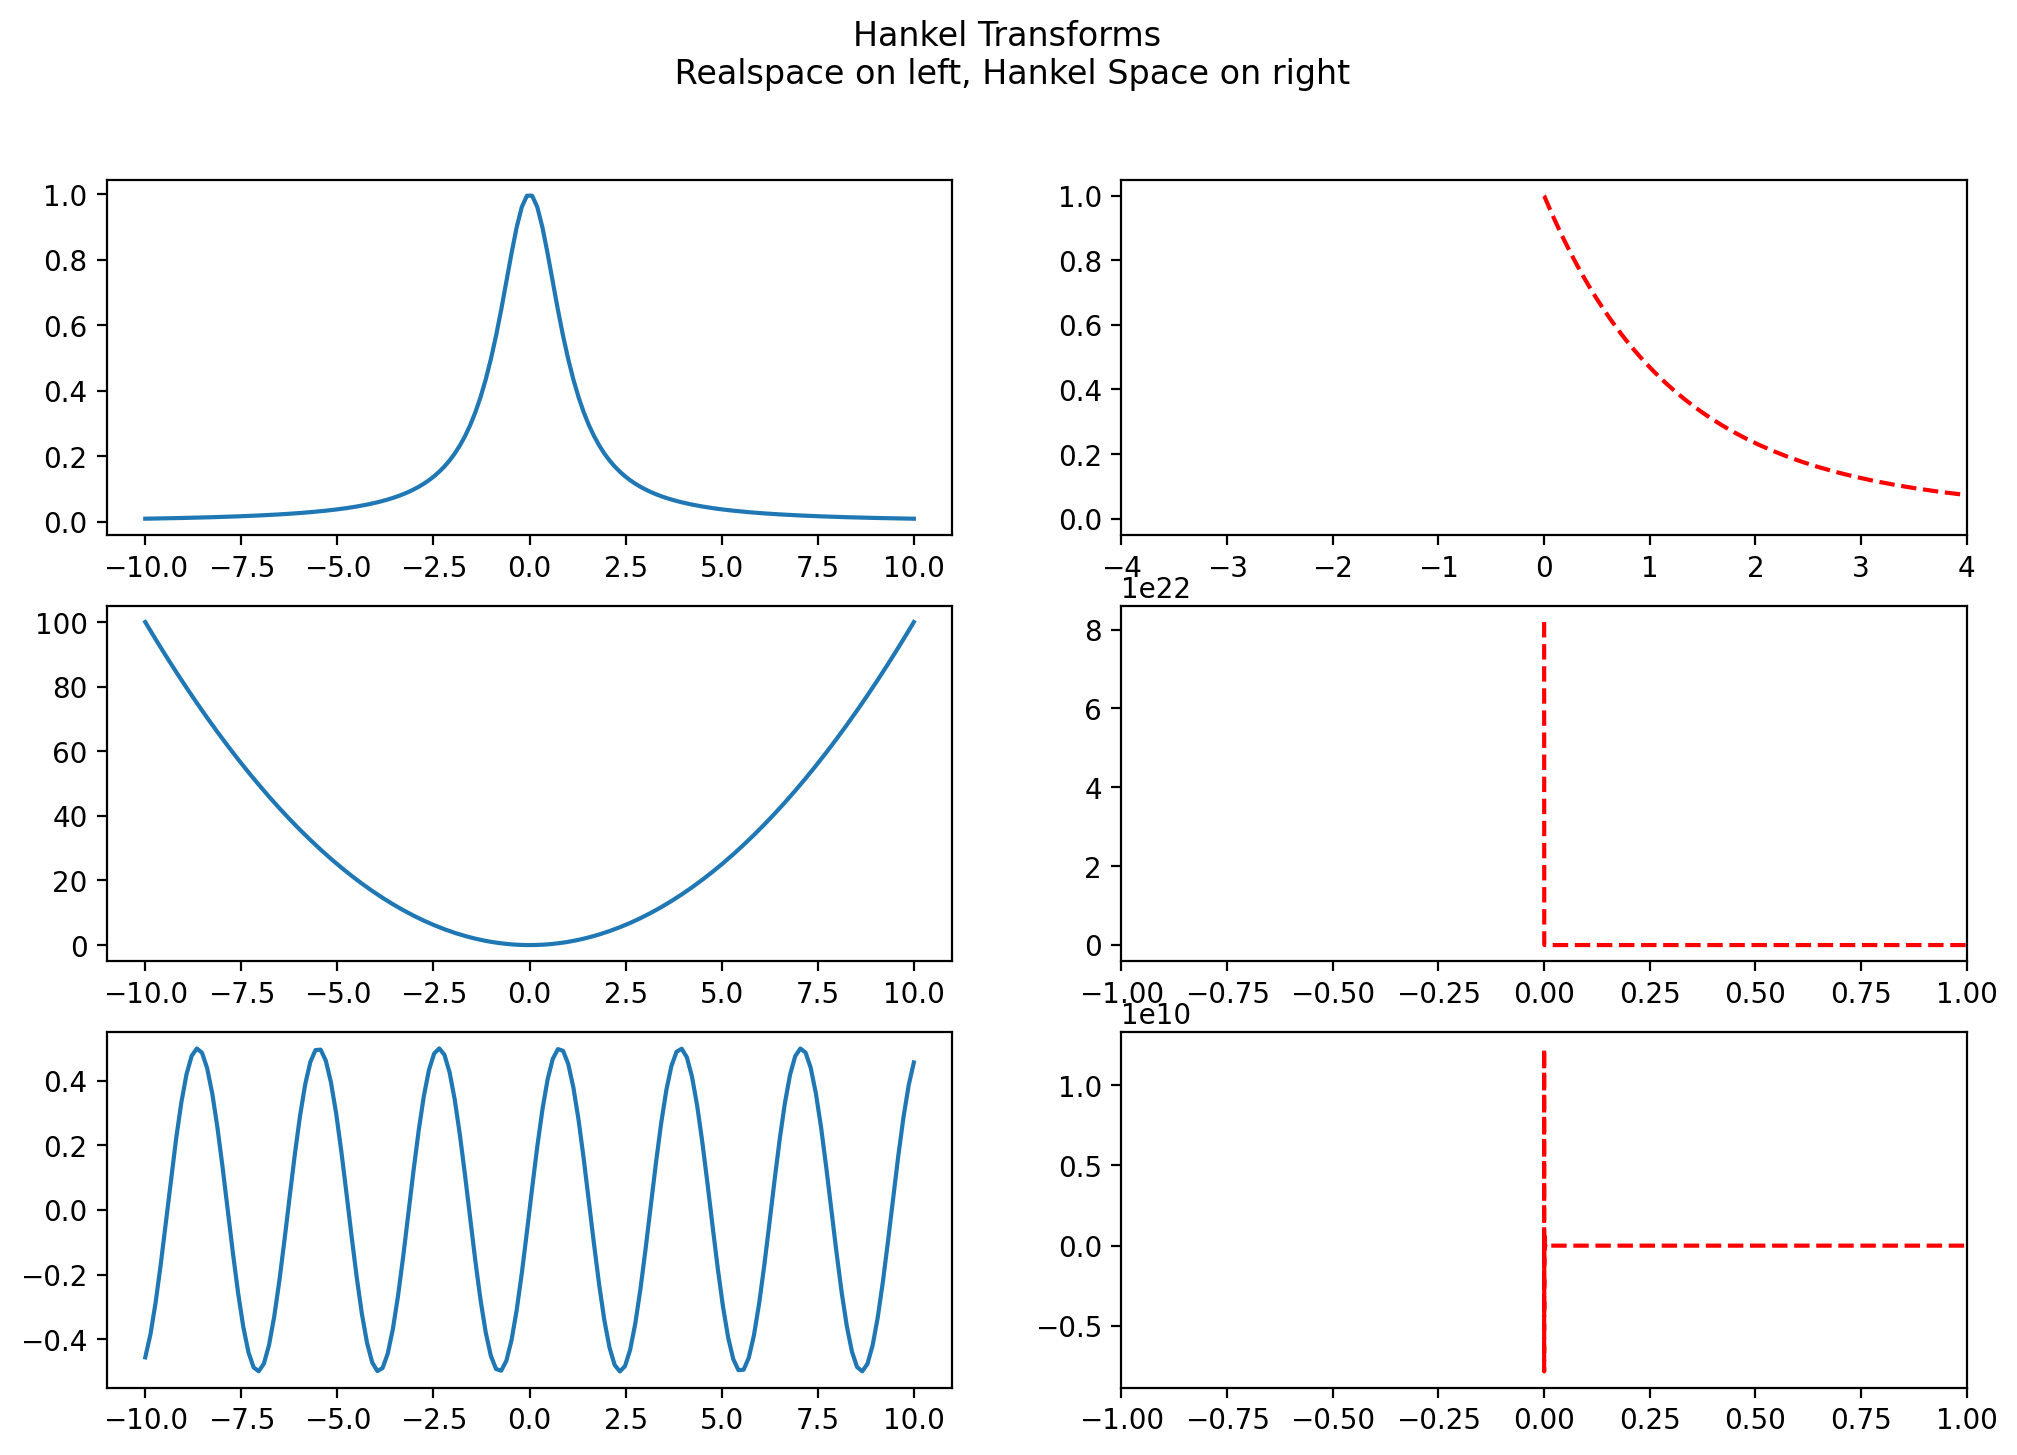

In [6]:
# Plot A
plt.figure(figsize=(12,8), dpi=200, facecolor='w', edgecolor='k')
plt.subplot(321)
plt.plot(realspace, a(realspace))
plt.suptitle("Hankel Transforms\n Realspace on left, Hankel Space on right")
plt.subplot(322)
plt.xlim([-4, 4])
plt.plot(hankelspace, h_a, "r--")
# Plot B
plt.subplot(323)
plt.plot(realspace, b(realspace))
plt.subplot(324)
plt.plot(hankelspace, h_b, "r--")
plt.xlim([-1, 1])
# Plot C
plt.subplot(325)
plt.plot(realspace, c(realspace))
plt.subplot(326)
plt.plot(hankelspace, h_c, "r--")
plt.xlim([-1, 1])

Inverting the Hankel transformations to recover $f(x)$

In [7]:
# Compute inverse hankel transformations by splining the discrete hankel transformation and running the inverse 
spline_a = spline(hankelspace, h_a)
spline_b = spline(hankelspace, h_b)
spline_c = spline(hankelspace, h_c)

recover_a = ht.transform(spline_a, realspace, inverse=True, ret_err=False)
recover_b = ht.transform(spline_b, realspace, inverse=True, ret_err=False)
recover_c = ht.transform(spline_c, realspace, inverse=True, ret_err=False)

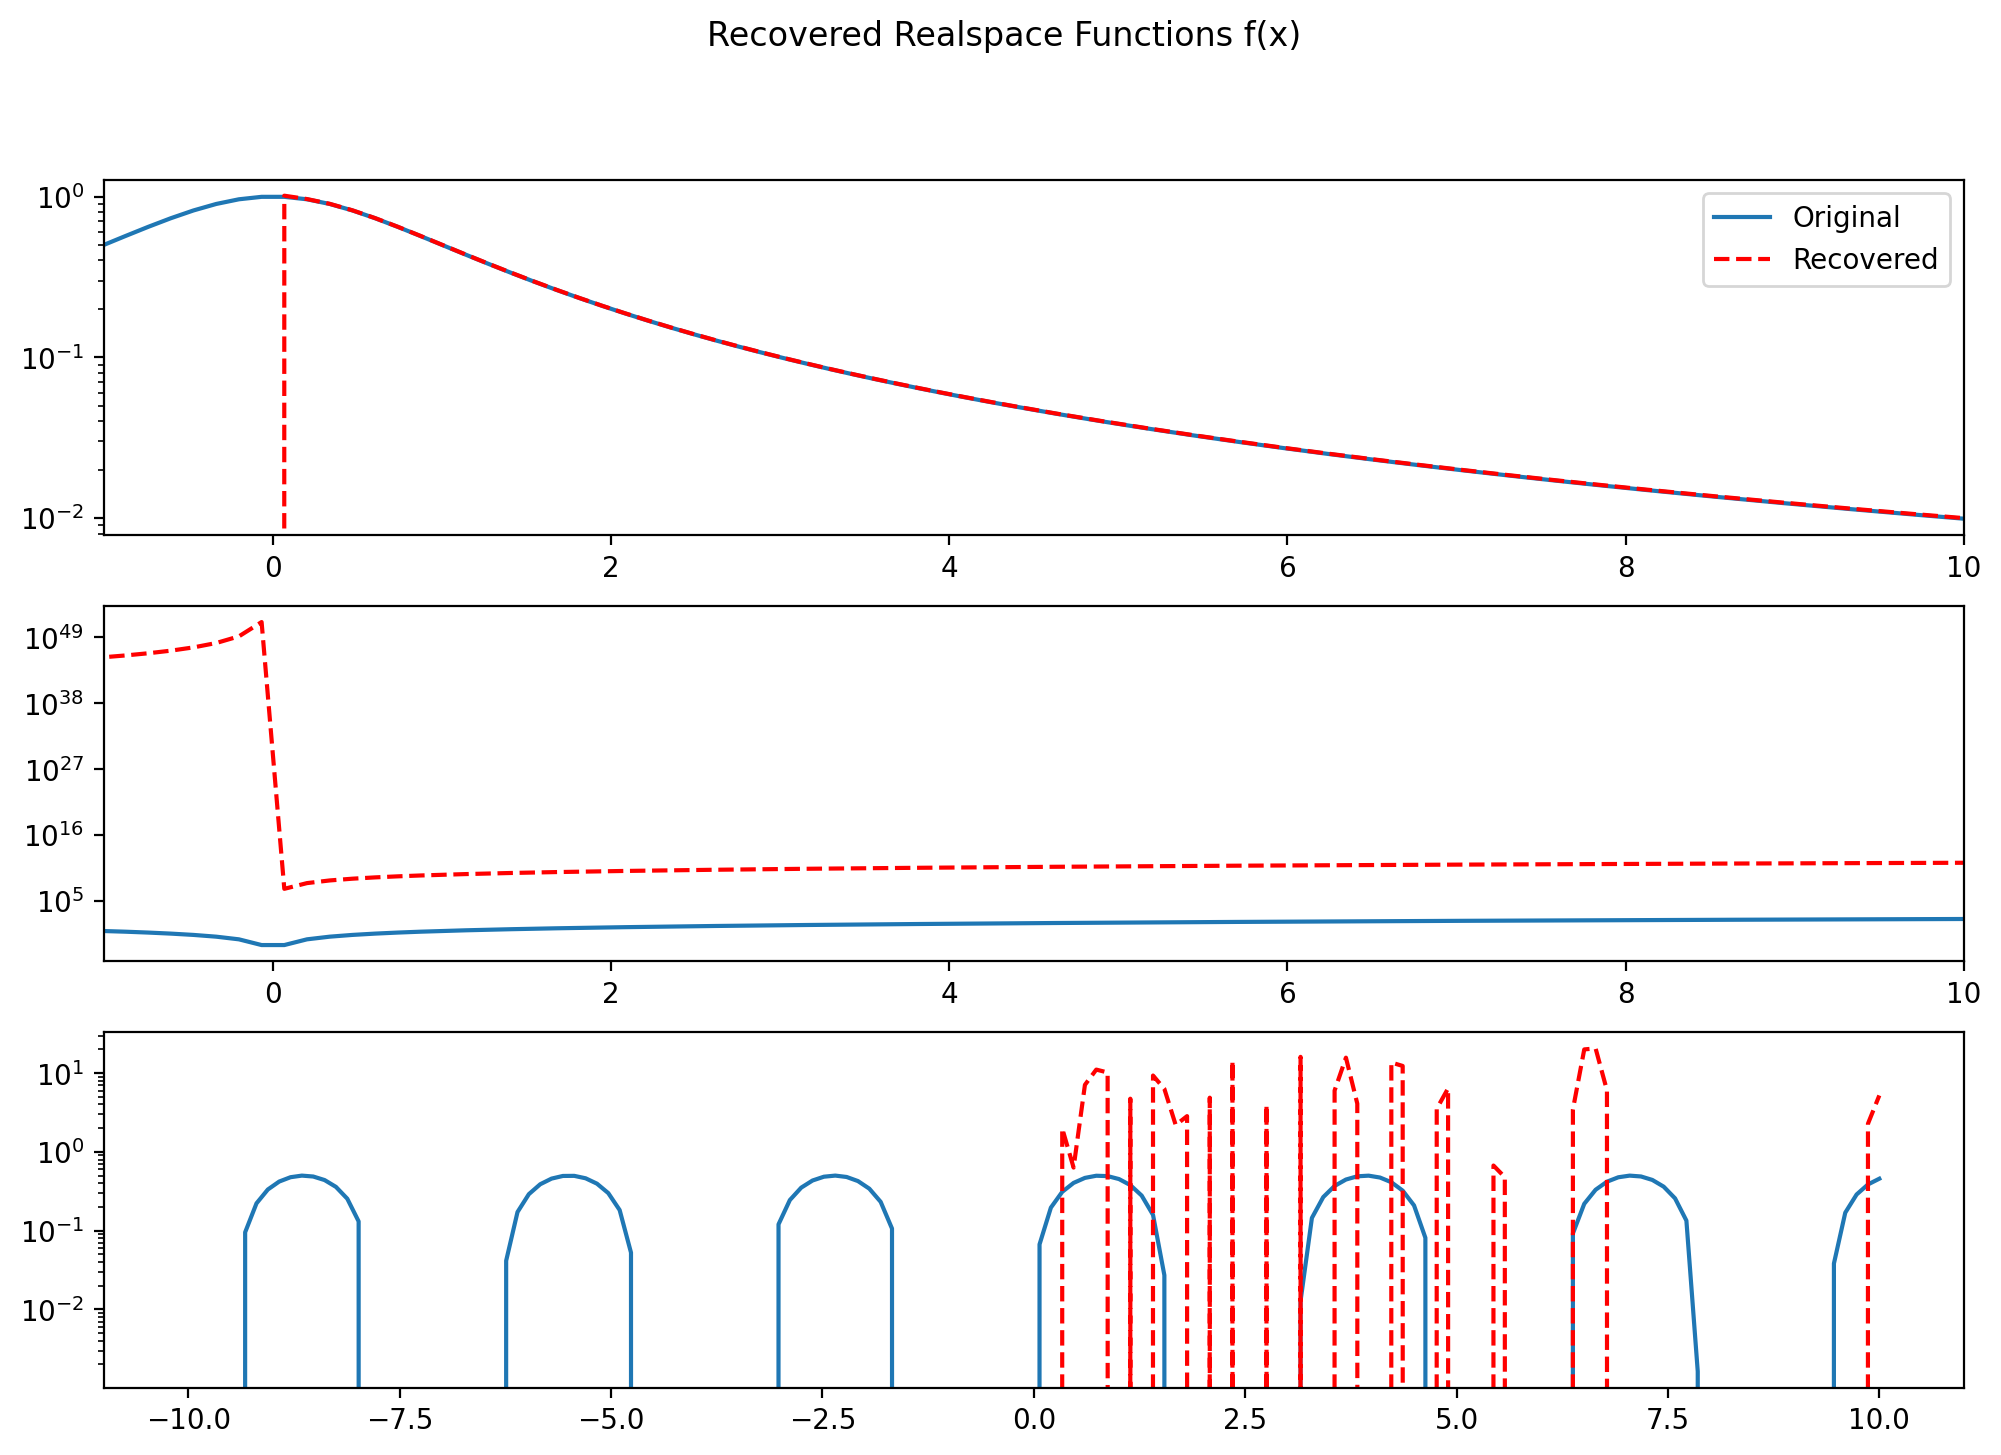

In [8]:
# Recovered A
plt.figure(figsize=(12,8), dpi=200, facecolor='w', edgecolor='k')
plt.suptitle("Recovered Realspace Functions f(x)")
plt.subplot(311)
plt.plot(realspace, a(realspace), label='Original')
plt.plot(realspace, recover_a, "r--", label='Recovered')
plt.xlim([-1,10])
plt.yscale('log')
plt.legend()
# Recovered B
plt.subplot(312)
plt.plot(realspace, b(realspace))
plt.plot(realspace, recover_b, "r--")
plt.xlim([-1,10])
plt.yscale('log')
# Recovered C
plt.subplot(313)
plt.plot(realspace, c(realspace))
plt.plot(realspace, recover_c, "r--")
plt.yscale('log')

For the purposes of troubleshooting and visualization, we will use equation a:
    $$a = \frac{1}{r^2 + 1}$$

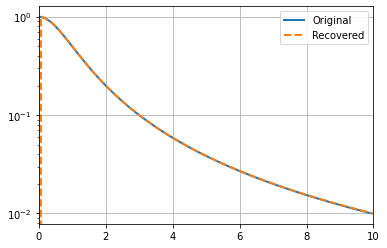

In [9]:
# Recovered, example taken from hankel user guide

fig,ax = plt.subplots(1,1,sharex=True,gridspec_kw={"hspace":0})

ax.semilogy(realspace,a(realspace), linewidth=2,label='Original')
ax.semilogy(realspace,recover_a,ls='--',linewidth=2,label='Recovered')
ax.grid(True)
ax.legend(loc='best')
ax.set_xlim(0,10)

#ax[1].plot(realspace, np.abs(a(realspace)/recover_a-1))
#ax[1].set_yscale('log')
#ax[1].set_ylim(None,30)
#ax[1].grid(True)
#ax[1].set_ylabel("Rel. Diff.")
plt.show()


# Digital Filters to obtain the Hankel Transform
### From Guptasarma and Singh, 1997

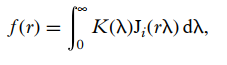

In [12]:
# Load the 47 point J1 filter from Guptasarma 1997
# n = 47

gupFilter = np.fromfile('gup1997J147pt.csv', float, sep=',')
print(f"n={len(gupFilter)} Filter loaded")
print(gupFilter)
r = np.array([1,2,3,4,5,6,7,8,9])

n=47 Filter loaded
[ 3.17926147e-06 -9.73811661e-06  1.64866227e-05 -1.81501261e-05
  1.87556556e-05 -1.14655041e-06  1.53799734e-05 -6.95628274e-06
  1.41881556e-05  3.41445666e-06  2.13941716e-05  2.34962369e-05
  4.84340283e-05  7.33732979e-05  1.27703784e-04  2.08120026e-04
  3.49803899e-04  5.79107815e-04  9.65887918e-04  1.60401274e-03
  2.66903778e-03  4.43111590e-03  7.35631696e-03  1.21782796e-02
  2.01097829e-02  3.30096953e-02  5.37143592e-02  8.60516613e-02
  1.34267607e-01  2.00125033e-01  2.74027506e-01  3.18168749e-01
  2.41655667e-01 -5.40549162e-02 -4.46912952e-01 -1.92231886e-01
  5.52376754e-01 -3.57429049e-01  1.41510519e-01 -4.61421935e-02
  1.48273762e-02 -5.07479209e-03  1.83829714e-03 -6.67742804e-04
  2.21277518e-04 -5.66248733e-05  7.88229203e-06]


In [61]:
# Abscissae:
def abscissaeJ1(r):
    # Returns the lambdas used in the method of Guptasarma and Singh 1997
    # function f(lambda) is evaluated at these lambdas
    
    # 47 point filter parameters:
    a = -3.05078187595e0
    s = 1.10599010095e-1
    rangefunc = np.arange(0, len(gupFilter))[:,np.newaxis]
    
    eval_points = 1 / r * np.power(10, a + vert * s)
    return eval_points

def filteredHankel(r, ufunc):
    # Calculates the J1 Hankel Transform with a 47 point filter
    # r: points to calculate the transform at
    # ufunc: callable function to be hankel transformed
    lambdas = abscissaeJ1(r)
    K = ufunc(lambdas)
    prod = np.multiply(gupFilter, K.T).sum(axis=1)
    return prod / r

filteredHankel(np.array([5]), a)

5.184705528587072e+21

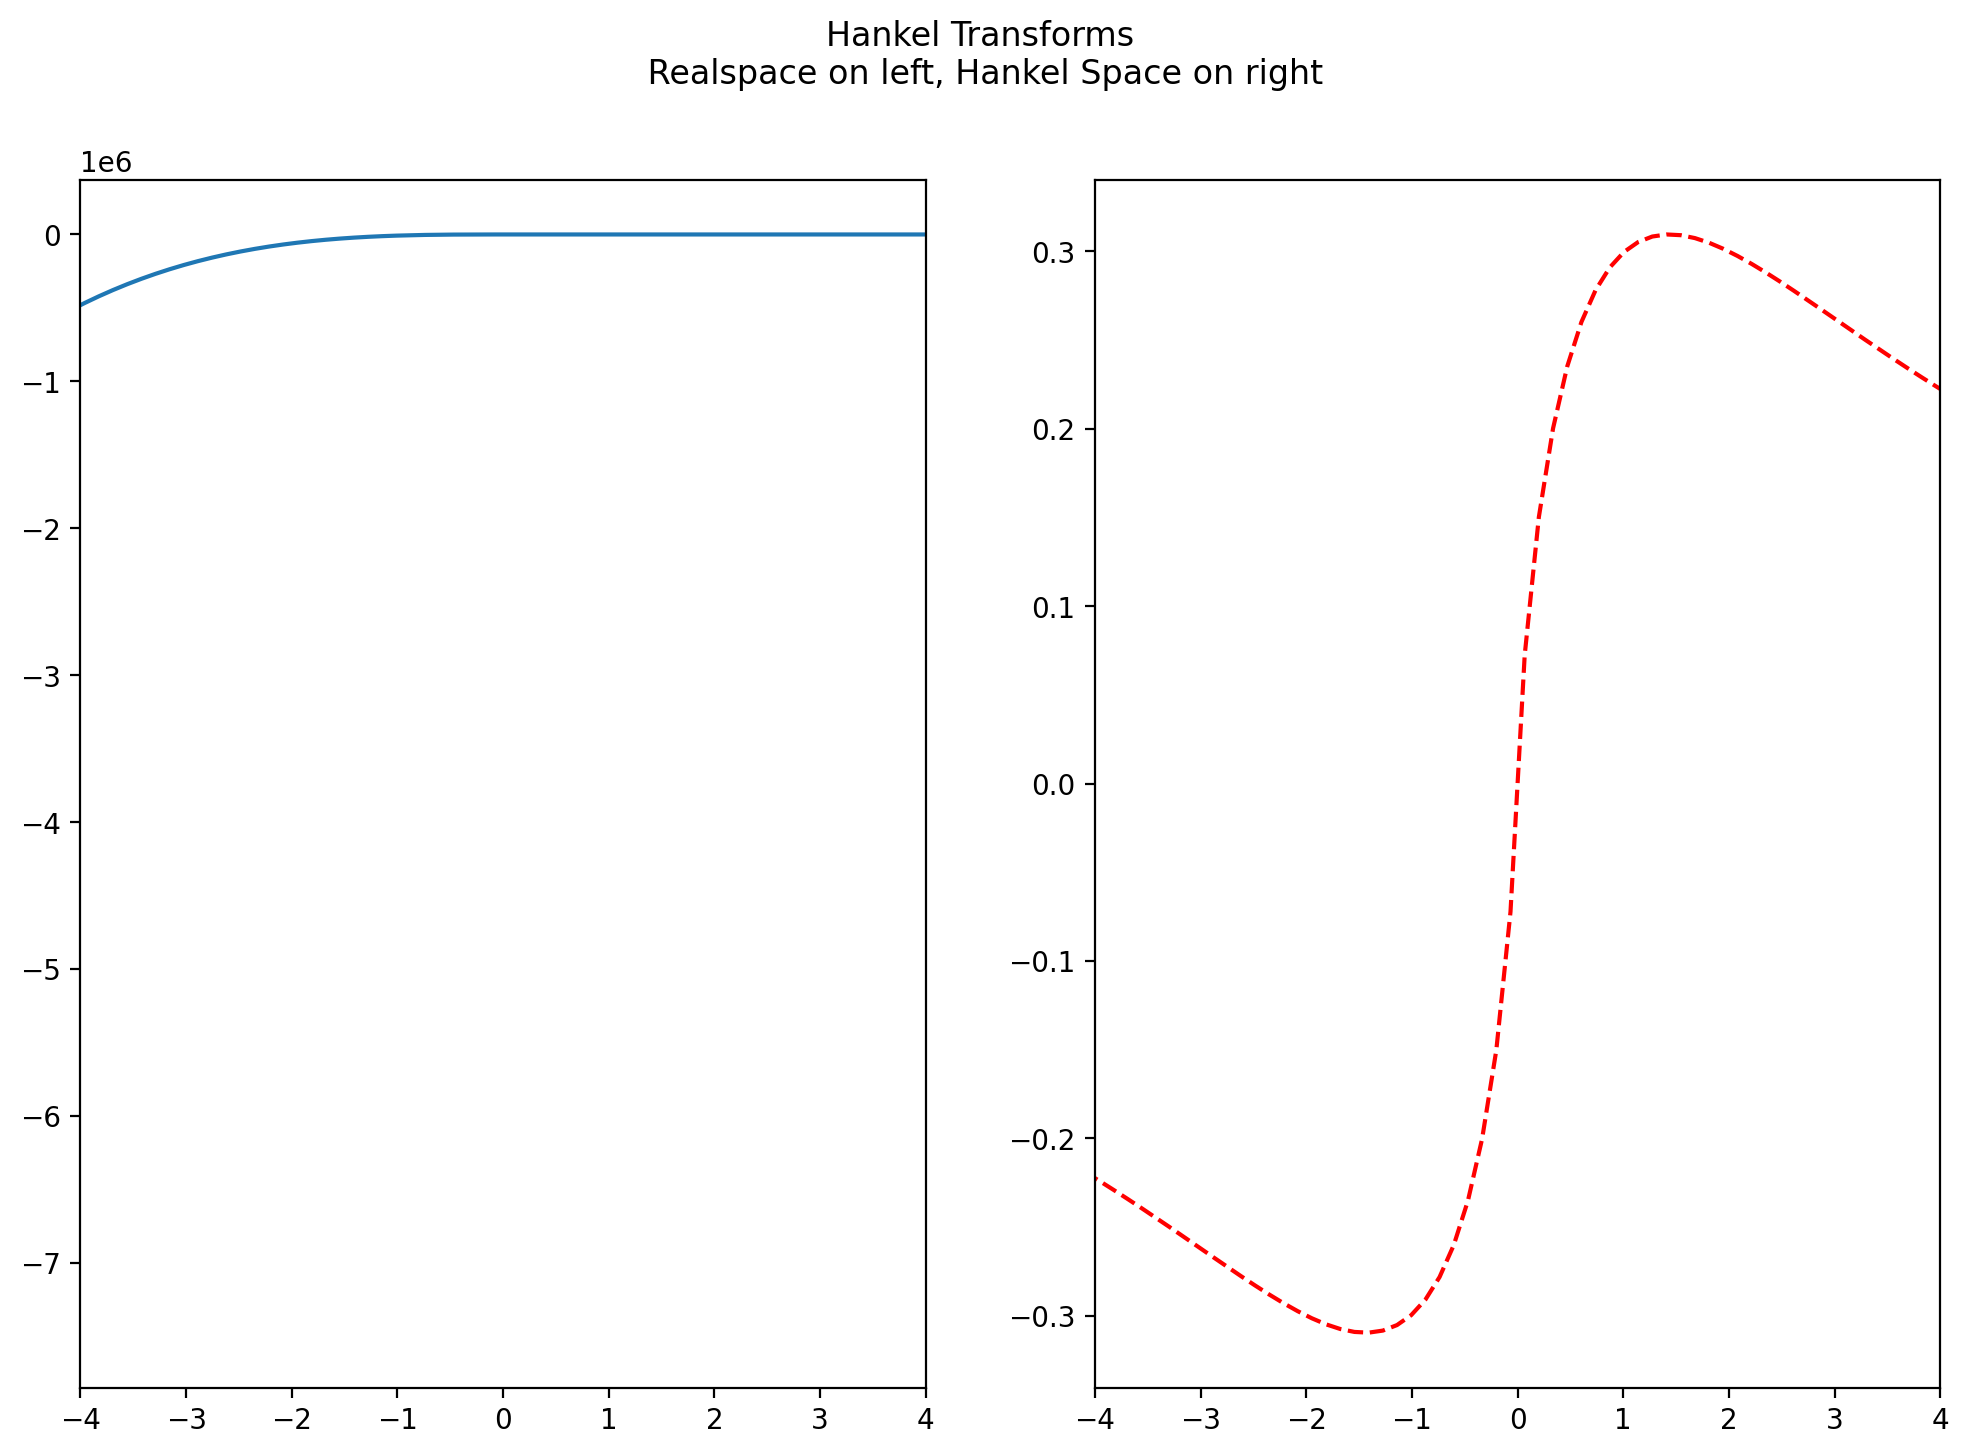

In [53]:
# Forward Hankel Testing
hf_a = filteredHankel(realspace, a)
# Plot A
plt.figure(figsize=(12,8), dpi=200, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.plot(realspace, spline_a(realspace))
plt.xlim([-4, 4])
plt.suptitle("Hankel Transforms\n Realspace on left, Hankel Space on right")
plt.subplot(122)
plt.xlim([-4, 4])
plt.plot(realspace, hf_a, "r--")
